# Import and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf

# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


import pandas
import h5py
import pickle

import datetime

2022-09-27 13:57:23.479045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
# configs
train, val, test = 0.6, 0.3, 0.1
Phi_sizes, F_sizes = (256, 256, 256), (256, 256, 256)
num_epoch = 200
batch_size = 1000

# Load and Process Data

In [4]:
signal_1_df = "/global/home/users/yifengh3/VAE/vec_data/signal/muon_only/B_signal_vector_muons.h5"
signal_2_df = "/global/home/users/yifengh3/VAE/vec_data/signal/muon_only/hv_vector_muons.h5"
raw_signal_1 = pandas.read_hdf(signal_1_df)
raw_signal_2 = pandas.read_hdf(signal_2_df)

In [5]:
print("signal_1 data shape: {}".format(raw_signal_1.shape))
print("signal_2 data shape: {}".format(raw_signal_2.shape))

signal_1 data shape: (163600, 8)
signal_2 data shape: (155841, 200)


In [6]:
raw_signal_1

,pT0,eta0,phi0,E0,pT1,eta1,phi1,E1
0,7.26965,0.950225,2.301950,7.26965,11.48740,1.359730,-0.295626,11.48740
1,16.41760,-0.005042,3.114020,16.41760,6.70218,-0.075643,-3.109000,6.70218
2,8.53064,-0.632029,0.635732,8.53064,5.66312,-0.780046,-2.185410,5.66312
3,8.24784,-1.179380,-1.986270,8.24784,7.76347,-1.297750,-2.016260,7.76347
4,4.66563,0.870844,2.556970,4.66563,6.35399,1.049620,2.567710,6.35399
...,...,...,...,...,...,...,...,...
404,14.19430,-1.962120,1.553240,14.19430,7.13258,-1.865760,1.561710,7.13258
405,4.89570,0.914380,0.856134,4.89570,9.95881,0.774413,0.856637,9.95881
406,4.77840,1.973420,-0.022314,4.77840,4.51616,2.174490,0.039430,4.51616
407,12.98580,-1.910120,-0.659677,12.98580,11.29670,-1.830190,-0.670773,11.29670


In [7]:
#Truncate the nan
signal_1 = raw_signal_1.to_numpy()[:,:8]
signal_2 = raw_signal_2.to_numpy()[:,:8]

In [8]:
np.mean(signal_1,axis=0)

array([8.72264719e+00, 5.20708337e-02, 3.41632807e-02, 8.72264719e+00,
       7.92356296e+00, 7.87889927e-03, 1.07259135e-01, 7.92356296e+00])

In [9]:
print("signal_1 data shape: {}".format(signal_1.shape))
print("signal_2 data shape: {}".format(signal_2.shape))

signal_1 data shape: (163600, 8)
signal_2 data shape: (155841, 8)


In [10]:
# assign labels to signal and background data, 0 for sig1,  1 for sig2
# (updated since we might get multiple signals) 
labeled_sig1 = np.append(signal_1,np.zeros((signal_1.shape[0],1)),axis=1)
labeled_sig2 = np.append(signal_2,np.ones((signal_2.shape[0],1)),axis=1)

In [11]:
# mix two data array into one signal array
data = np.concatenate((labeled_sig1,labeled_sig2))

#and shuffle the data
np.random.shuffle(data)

In [12]:
X = data[:,:-1]
y = data[:,-1]

In [13]:
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

shape of X: (319441, 8)
shape of Y: (319441,)


In [14]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = labeled_sig1.shape[0] + labeled_sig2.shape[0]
weight_for_0 = (1 / labeled_sig1.shape[0]) * (total / 2.0)
weight_for_1 = (1 / labeled_sig2.shape[0]) * (total / 2.0)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for background: {:.2f}'.format(weight_for_0))
print('Weight for signal: {:.2f}'.format(weight_for_1))

Weight for background: 0.98
Weight for signal: 1.02


In [15]:
# To categorical as stipulated in example
Y = to_categorical(y, num_classes=2)

# Reshape X to shape (number of jets, 50, 4)
X = X.reshape(-1,2,4)

# ignore the pid info
X = X[:,:,:3]

In [16]:
print(X.shape)

(319441, 2, 3)


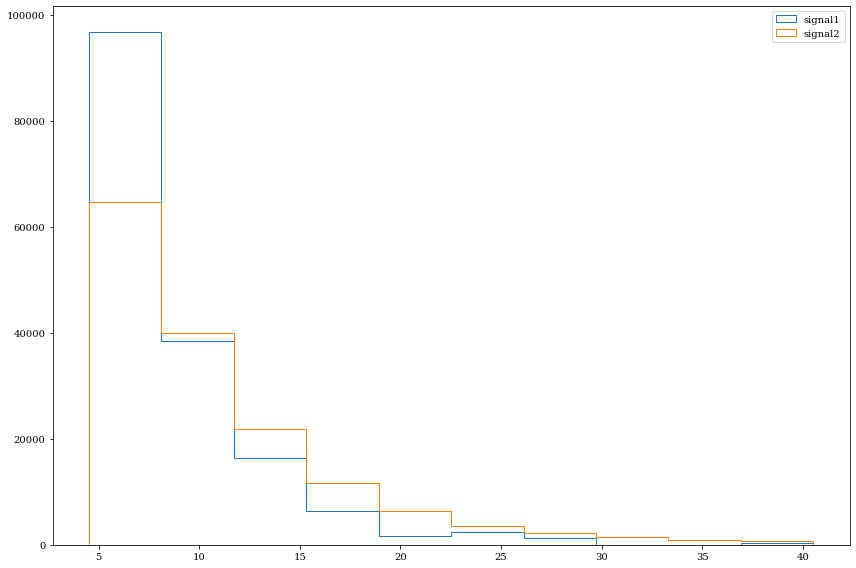

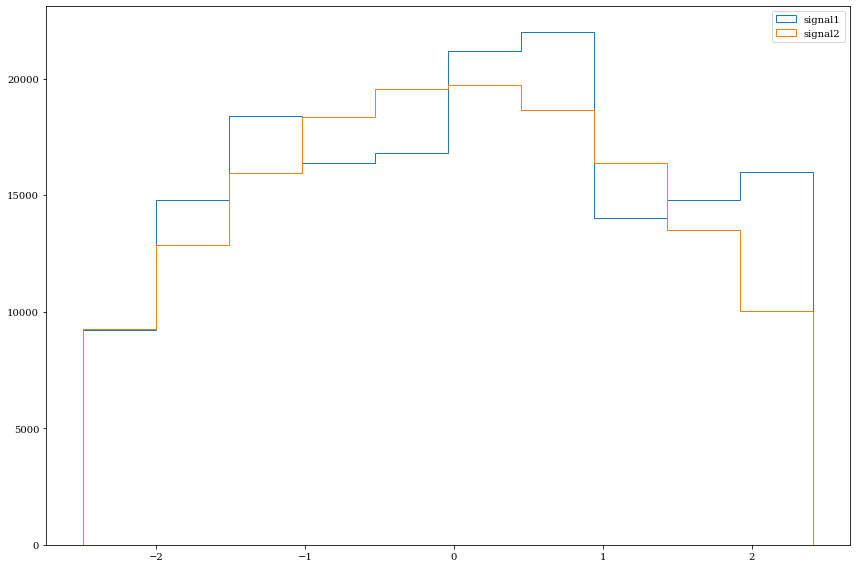

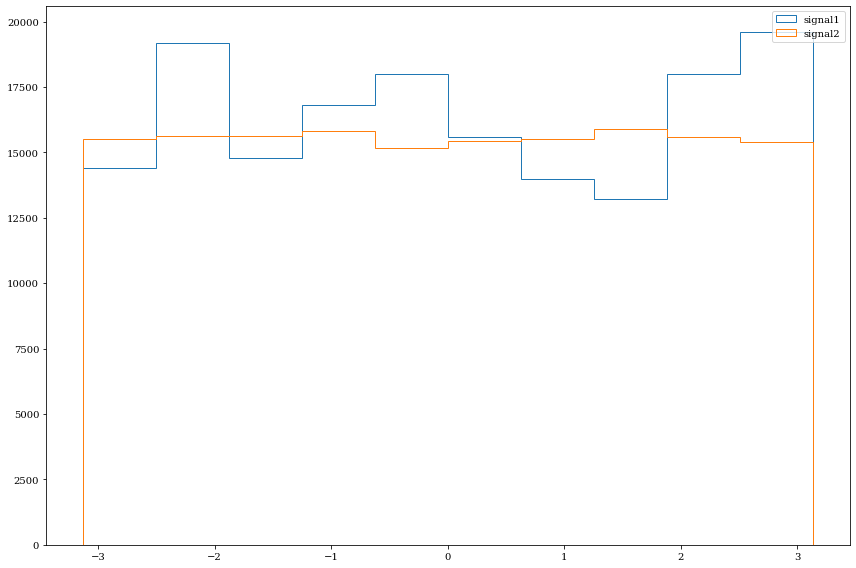

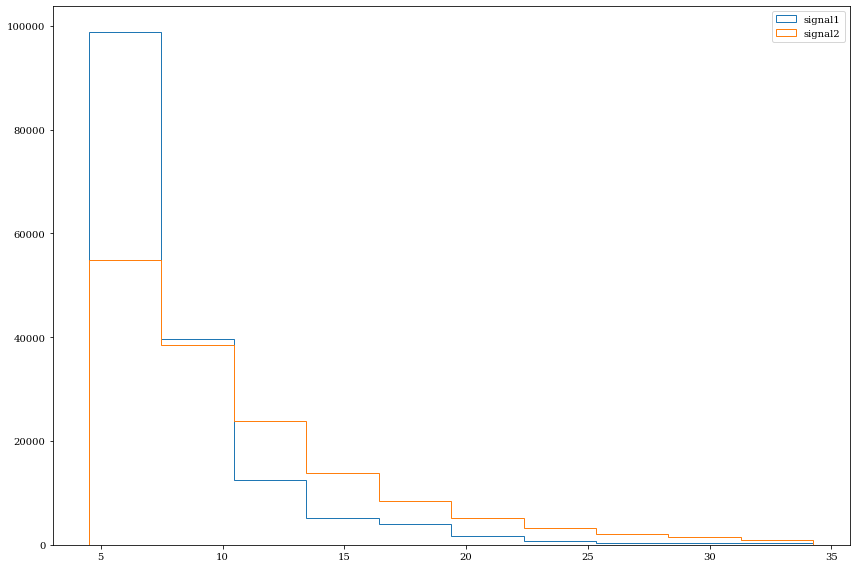

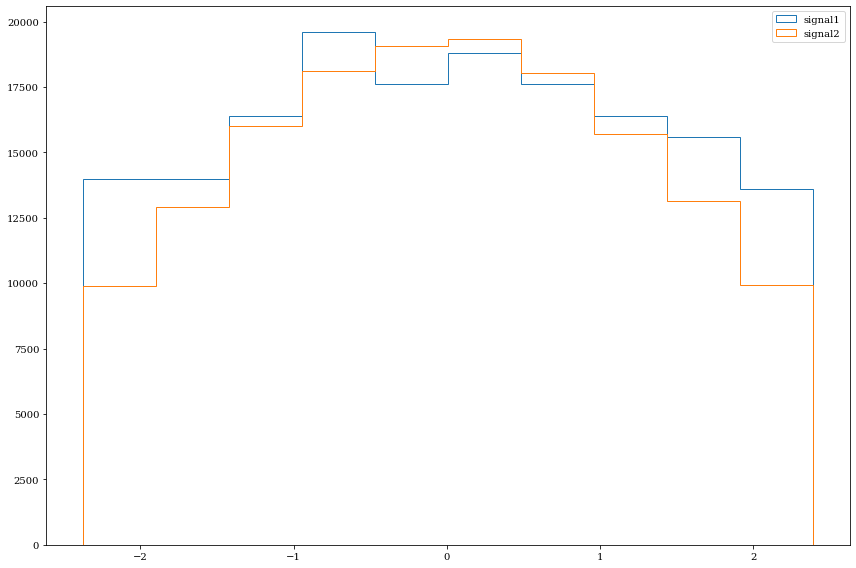

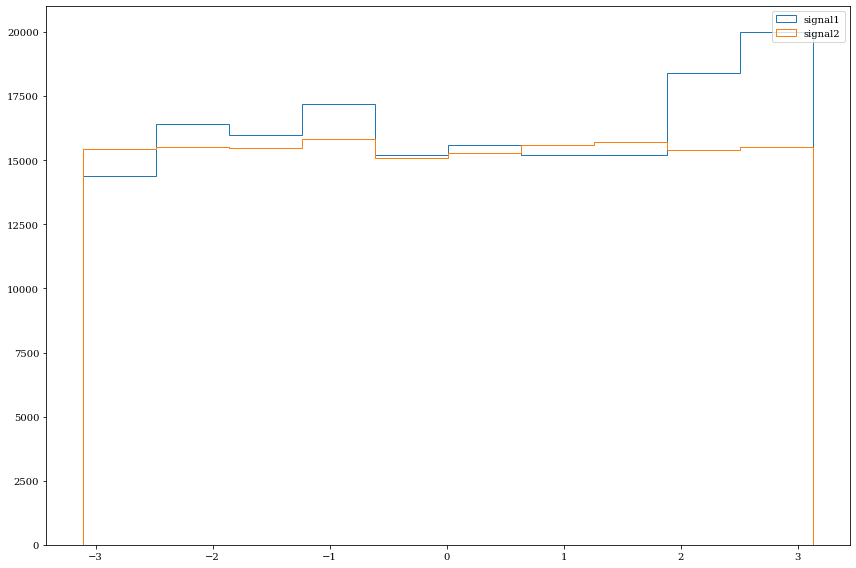

In [38]:
for i in range(6):
    plt.figure(figsize=(12,8))
    _,b,_ = plt.hist(X.reshape([-1,6])[y==0,i], label="signal1", histtype="step")
    plt.hist(X.reshape([-1,6])[y==1,i], label="signal2", histtype="step", bins=b)
    plt.legend()
    plt.show()

In [40]:
%cd ../recon_kinematic_plot

/global/home/users/yifengh3/VAE/EMD_VAE/recon_kinematic_plot


In [41]:
from plot_utils import event_mass

In [42]:
em1 = event_mass(X[y==0])
em2 = event_mass(X[y==1])

100%|████████████████████████████████| 155841/155841 [00:04<00:00, 33159.97it/s]


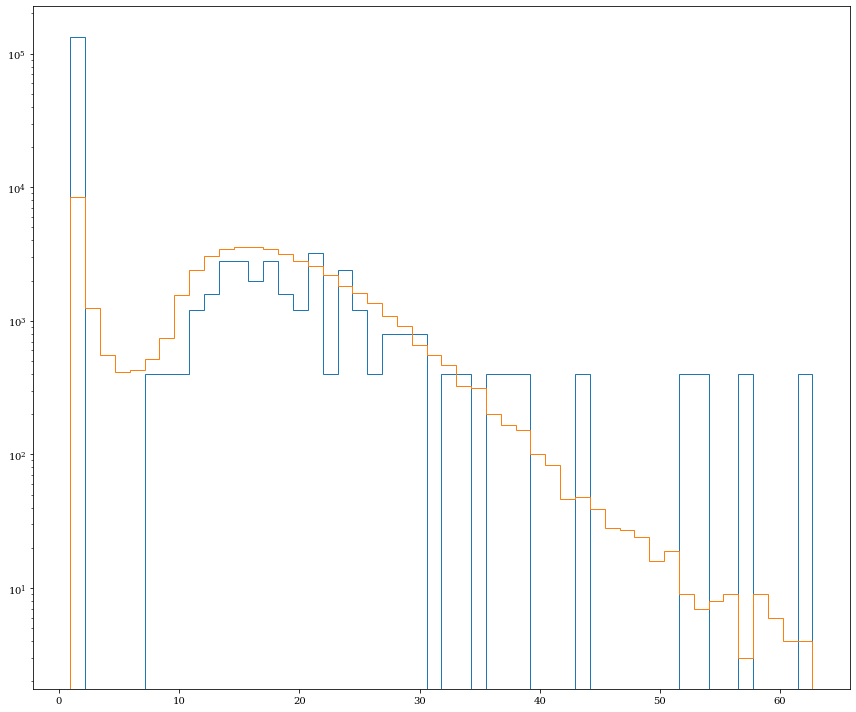

In [48]:
plt.figure(figsize=(12,10))
_,b,_ = plt.hist(em1, label = "EM_sig1", histtype="step", bins=50)
plt.hist(em2, label = "EM_sig2", bins=b, histtype="step")
plt.yscale("log")
plt.show()

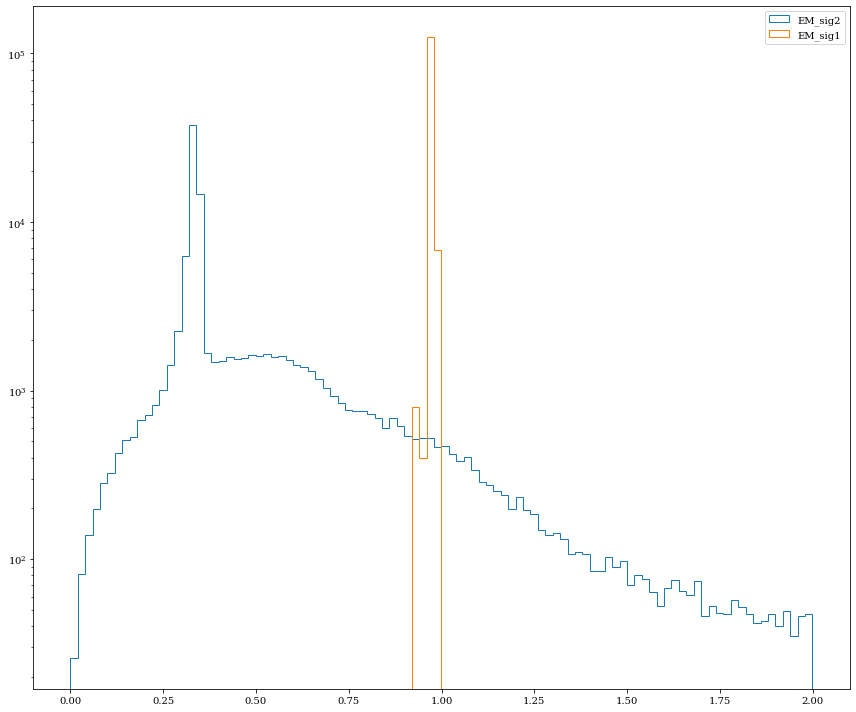

In [56]:
plt.figure(figsize=(12,10))
_,b,_ = plt.hist(em2[em2<2], label = "EM_sig2", histtype="step", bins=100)
plt.hist(em1[em1<2], label = "EM_sig1", bins=b, histtype="step")
plt.yscale("log")
plt.legend()
plt.show()

In [62]:
print(np.logical_and(em1>0.9, em1<1).sum()/em1.shape[0])
np.logical_and(em2>0.25, em2<).sum()

0.8092909535452323


In [17]:
# # normalizing jets
# # copied from example
# import tqdm
# for x in tqdm.tqdm(X):
#     # now add the status bar :)
#     mask = x[:,0] > 0
#     yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
#     x[mask,1:3] -= yphi_avg
#     x[mask,0] /= x[:,0].sum()

In [57]:
# set EM limit
em = event_mass(X)
em_idx = em[em<2]

100%|████████████████████████████████| 319441/319441 [00:09<00:00, 32138.96it/s]


In [18]:
print('Finished preprocessing')
print("shape of X: {}".format(X.shape))
print("shape of Y: {}".format(y.shape))

Finished preprocessing
shape of X: (319441, 2, 3)
shape of Y: (319441,)


In [19]:
X = X.astype('float64')[em_idx]

In [20]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=val, test=test)

# Build and Train the Model

In [21]:
print('Model summary:')

# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

Model summary:


2022-09-27 13:57:46.769183: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-27 13:57:46.770458: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-09-27 13:57:46.803160: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-09-27 13:57:46.803181: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-09-27 13:57:46.804481: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-09-27 13:57:46.804509: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-0

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 256)    1024        input[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, None, 256)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 256)    65792       activation[0][0]                 
______________________________________________________________________________________________

In [22]:
# now train the model

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1**(1/5), patience=5, min_lr=1e-5,
                                                verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, 
                                              verbose=1)

callbacks = [reduce_lr,early_stop]

hist1 = pfn.fit(X_train, Y_train,
        epochs=num_epoch,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1)

Epoch 1/200


2022-09-27 13:57:47.805917: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-27 13:57:47.806361: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2994530000 Hz


  1/192 [..............................] - ETA: 1:46 - loss: 7.4398 - acc: 0.4830

2022-09-27 13:57:48.196520: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


192/192 [==============================] - 2s 5ms/step - loss: 3.4530 - acc: 0.5674 - val_loss: 0.6875 - val_acc: 0.5748
Epoch 2/200
192/192 [==============================] - 1s 4ms/step - loss: 0.6358 - acc: 0.6351 - val_loss: 0.6358 - val_acc: 0.6351
Epoch 3/200
192/192 [==============================] - 1s 4ms/step - loss: 0.5895 - acc: 0.6826 - val_loss: 0.5612 - val_acc: 0.7028
Epoch 4/200
192/192 [==============================] - 1s 4ms/step - loss: 0.5705 - acc: 0.6957 - val_loss: 0.5397 - val_acc: 0.7312
Epoch 5/200
192/192 [==============================] - 1s 4ms/step - loss: 0.5386 - acc: 0.7211 - val_loss: 0.6109 - val_acc: 0.6615
Epoch 6/200
192/192 [==============================] - 1s 4ms/step - loss: 0.5200 - acc: 0.7336 - val_loss: 0.5037 - val_acc: 0.7476
Epoch 7/200
192/192 [==============================] - 1s 4ms/step - loss: 0.4938 - acc: 0.7521 - val_loss: 0.4899 - val_acc: 0.7584
Epoch 8/200
192/192 [==============================] - 1s 3ms/step - loss: 0.4587

192/192 [==============================] - 1s 4ms/step - loss: 0.0168 - acc: 0.9958 - val_loss: 0.0283 - val_acc: 0.9918
Epoch 62/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0178 - acc: 0.9954 - val_loss: 0.0203 - val_acc: 0.9947
Epoch 63/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0226 - acc: 0.9941 - val_loss: 0.0264 - val_acc: 0.9926
Epoch 64/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0208 - acc: 0.9947 - val_loss: 0.0269 - val_acc: 0.9926
Epoch 65/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0255 - acc: 0.9931 - val_loss: 0.0371 - val_acc: 0.9897
Epoch 66/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0288 - acc: 0.9927 - val_loss: 0.0314 - val_acc: 0.9919
Epoch 67/200
192/192 [==============================] - 1s 4ms/step - loss: 0.0176 - acc: 0.9955 - val_loss: 0.0241 - val_acc: 0.9941

Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.000251188657425

# Analyze the Model

In [23]:
# get predictions on test data
preds = pfn.predict(X_test, batch_size=10000)

# get ROC curve
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# get area under the ROC curve
auc = roc_auc_score(Y_test[:,1], preds[:,1])
print()
print('PFN AUC:', auc)
print()


PFN AUC: 0.999634517479256



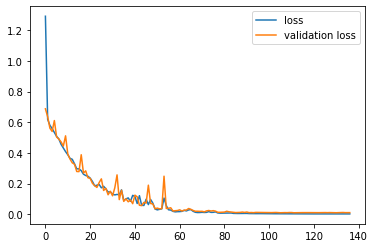

In [24]:
plt.plot(hist1.history["loss"],label="loss")
plt.plot(hist1.history["val_loss"],label="validation loss")
plt.legend()
plt.show()

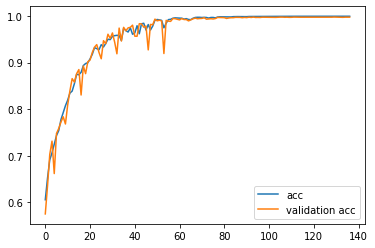

In [25]:
plt.plot(hist1.history["acc"],label="acc")
plt.plot(hist1.history["val_acc"],label="validation acc")
plt.legend()
plt.show()

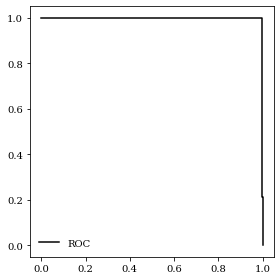

In [26]:
# get multiplicity and mass for comparison
preds = pfn.predict(X_test, batch_size=1000)
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1-pfn_fp, '-', color='black', label='ROC')

plt.legend(loc='lower left', frameon=False)

plt.show()

/tmp/ipykernel_21318/1246046417.py:11: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(pfn_tp, 1/pfn_fp, '-', color='black', label='ROC')


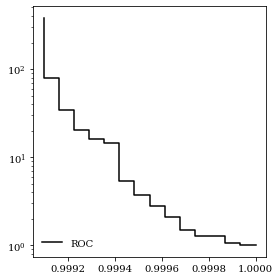

In [27]:
# get multiplicity and mass for comparison
preds = pfn.predict(X_test, batch_size=1000)
pfn_fp, pfn_tp, threshs = roc_curve(Y_test[:,1], preds[:,1])

# some nicer plot settings 
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.autolayout'] = True

# plot the ROC curves
plt.plot(pfn_tp, 1/pfn_fp, '-', color='black', label='ROC')

plt.yscale('log')

plt.legend(loc='lower left', frameon=False)

plt.show()